In [1]:
%env THEANO_FLAGS='device=gpu0','floatX=float32'

import os
import os.path as osp

import numpy as np

import theano
import theano.tensor as T
from lasagne import *

%matplotlib nbagg

import matplotlib.pyplot as plt

env: THEANO_FLAGS='device=gpu0','floatX=float32'


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
import sklearn

print sklearn.__version__

0.18


In [3]:
%%sh

wget -q -nc https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py

In [4]:
### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

In [5]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [6]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')

In [7]:
from ae import CAE

In [8]:
cae = CAE(n_codes=16)
cae.load('CAE_16.npz')

In [9]:
X = cae.decode(cae.encode(X))
X_test = cae.decode(cae.encode(X_test))

In [11]:
class Clf(Net):
    def __init__(self, X_batch):
        super(Clf, self).__init__()
        
        input_l = layers.InputLayer(shape=(None, 1, 28, 28), input_var=X_batch)

        conv1 = layers.Conv2DLayer(
            input_l,
            num_filters=16,
            filter_size=(3, 3),
            nonlinearity=nonlinearities.elu
        )
        
        conv2 = layers.Conv2DLayer(
            conv1,
            num_filters=32,
            filter_size=(3, 3),
            nonlinearity=nonlinearities.elu
        )

        pool1 = layers.GlobalPoolLayer(
            conv2,
            pool_function=T.mean
        )

        dense = layers.DenseLayer(
            pool1,
            num_units = 1,
            nonlinearity=nonlinearities.sigmoid
        )
        
        self.net = dense
        
        self.predictions = T.flatten(layers.get_output(dense))

In [12]:
class Reweighter(Net):
    def __init__(self, X_batch):
        super(Reweighter, self).__init__()
        
        input_l = layers.InputLayer(shape=(None, 1, 28, 28), input_var=X_batch)

        conv1 = layers.Conv2DLayer(
            input_l,
            num_filters=16,
            filter_size=(3, 3),
            nonlinearity=nonlinearities.elu
        )
        
        conv2 = layers.Conv2DLayer(
            conv1,
            num_filters=32,
            filter_size=(3, 3),
            nonlinearity=nonlinearities.elu
        )

        pool1 = layers.GlobalPoolLayer(
            conv2,
            pool_function=T.mean
        )

        dense = layers.DenseLayer(
            pool1,
            num_units = 1,
            nonlinearity=nonlinearities.sigmoid
        )
        
        self.net = dense
        
        self.weights = T.flatten(layers.get_output(dense))

In [13]:
X_batch = T.ftensor4(name='X_batch')

clf = Clf(X_batch)
reweighter = Reweighter(X_batch)

print clf
print
print reweighter

  output shape:(None, 1, 28, 28)
  number of params: 0.0
  output shape:(None, 16, 26, 26)
  number of params: 288
  output shape:(None, 32, 24, 24)
  number of params: 9216
  output shape:(None, 32)
  number of params: 0.0
  output shape:(None, 1)
  number of params: 64

  output shape:(None, 1, 28, 28)
  number of params: 0.0
  output shape:(None, 16, 26, 26)
  number of params: 288
  output shape:(None, 32, 24, 24)
  number of params: 9216
  output shape:(None, 32)
  number of params: 0.0
  output shape:(None, 1)
  number of params: 64


In [14]:
y_batch = T.fvector(name='y')

p_batch = clf.predictions

pure_loss = -T.mean(
    y_batch * T.log(p_batch) + (1 - y_batch) * T.log(1 - p_batch)
)

reg_clf = regularization.regularize_network_params(clf.net, regularization.l2)

loss = pure_loss + 1.0e-5 * (reg_clf)

In [15]:
p_batch.eval({X_batch : X[:10]}).shape

(10,)

In [16]:
loss.eval({
    X_batch : X[:10],
    y_batch : np.array([0 ] * 5 + [1] * 5, dtype='float32')
})

array(0.6935150623321533, dtype=float32)

In [17]:
clf_params = layers.get_all_params(clf.net)

In [18]:
learning_rate = T.fscalar('learning rate')

clf_upd = updates.adadelta(loss, clf_params, learning_rate=learning_rate)

In [19]:
train_clf = theano.function([X_batch, y_batch, learning_rate], pure_loss, updates=clf_upd)

In [22]:
codes = cae.encode(X)

codes_q95 = np.percentile(codes, q=95, axis=0)
codes_q05 = np.percentile(codes, q=5, axis=0)

codes_range = codes_q95 - codes_q05

def generate(size=1024):
    codes = np.random.uniform(size=(size, 16)) * codes_range[None, :] + codes_q05[None, :]
    return cae.decode(codes.astype('float32'))

<IPython.core.display.Javascript object>


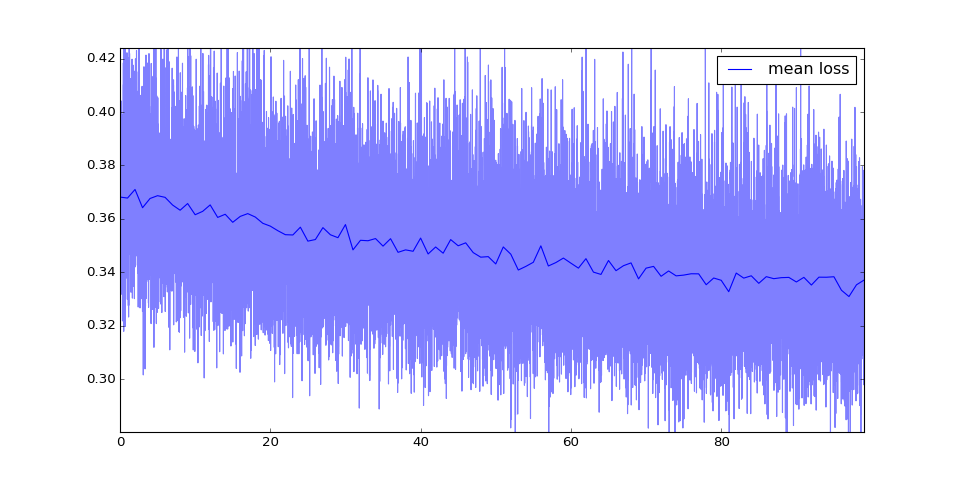

In [26]:
n_epoches = 100
n_batches = 256
batch_size = 2 ** 9

watcher = Watcher(n_epoches)

X_b = np.ndarray(shape=(2 * batch_size, 1, 28, 28), dtype='float32')
y_b = np.zeros(shape=(2 * batch_size, ), dtype='float32')
y_b[batch_size:] = 1.0

lr = np.float32(1.0)

losses = np.zeros(shape=(n_epoches, n_batches))

for epoch in xrange(n_epoches):
    stage = epoch

    for batch in xrange(n_batches):
        X_b[:batch_size] = generate(size=batch_size)
        
        indx = np.random.choice(X.shape[0], size=batch_size)
        X_b[batch_size:] = X[indx]
        
        losses[stage, batch] = train_clf(X_b, y_b, lr)
    watcher.draw(losses[:(epoch + 1)])